## Main Liberaries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load The Data

In [2]:
# Path to the dataset
data_path = '/kaggle/input/skin-cancer-malignant-vs-benign'

# Function to load images and labels
def load_data(dataset_path):
    images = []
    labels = []
    for label, category in enumerate(['benign', 'malignant']):
        category_path = os.path.join(dataset_path, 'train', category)
        for img_file in os.listdir(category_path):
            img_path = os.path.join(category_path, img_file)
            image = cv2.imread(img_path)
            image = cv2.resize(image, (150, 150))  # Resize images to a consistent size
            images.append(image)
            labels.append(label)  # Assign 0 for benign and 1 for malignant

    return np.array(images), np.array(labels)



In [3]:
# Load the training dataset
train_images, train_labels = load_data(data_path)

# Load the test dataset
test_images, test_labels = load_data(data_path.replace('train', 'test'))


## Split The Data

In [4]:
# Split the training data into train and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, 
                                                                      test_size=0.2, random_state=42)

## Normalize pixel values to a range of 0 to 1

In [5]:
# Normalize pixel values to a range of 0 to 1
train_images = train_images.astype('float32') / 255.0
val_images = val_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

## Show The Shapes

In [6]:
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (2109, 150, 150, 3)
Train labels shape: (2109,)
Validation images shape: (528, 150, 150, 3)
Validation labels shape: (528,)
Test images shape: (2637, 150, 150, 3)
Test labels shape: (2637,)


## Exploratory Data Analysis (EDA)

In [7]:
# Display some sample images from the training set
plt.figure(figsize=(18, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_images[i])
    if train_labels[i] == 0:
        plt.title("benign")
    else:
        plt.title("malignant")
    plt.axis('off')
plt.show()

#### ` Class Distribution`

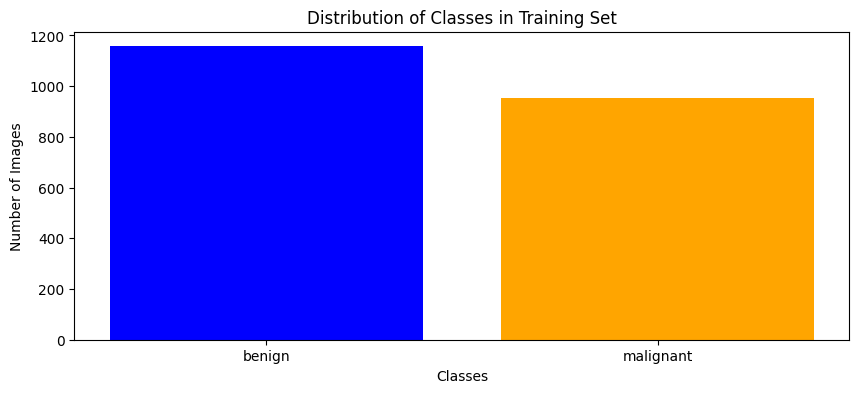

In [8]:
# Count the number of images for each class in the training set
unique, counts = np.unique(train_labels, return_counts=True)
class_count = dict(zip(unique, counts))

# Plotting the distribution of classes
plt.figure(figsize=(10, 4))
plt.bar(class_count.keys(), class_count.values(), color=['blue', 'orange'])
plt.xticks(list(class_count.keys()), ['benign', 'malignant'])
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in Training Set')
plt.show()


#### `Pixel Intensity Distribution`

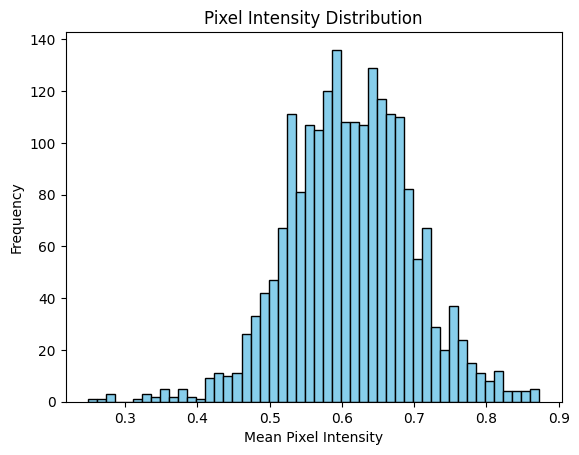

In [9]:
# Pixel Intensity Distribution
mean_intensities = [np.mean(img) for img in train_images]

plt.hist(mean_intensities, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Mean Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
plt.show()


### `Visualizing Image Dimensions`

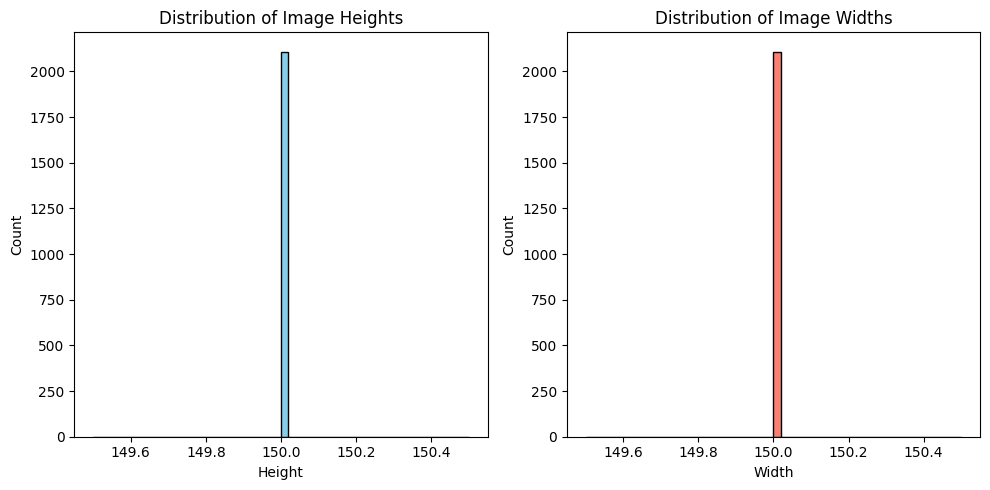

In [10]:
# Visualizing image dimensions in the dataset
img_dimensions = [img.shape for img in train_images]
heights = [dim[0] for dim in img_dimensions]
widths = [dim[1] for dim in img_dimensions]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(heights, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Image Heights')
plt.xlabel('Height')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(widths, bins=50, color='salmon', edgecolor='black')
plt.title('Distribution of Image Widths')
plt.xlabel('Width')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


#### `class percentages`

In [11]:
# Calculate class percentages
unique, counts = np.unique(train_labels, return_counts=True)
class_percentages = [count / len(train_labels) for count in counts]

# Create a pie chart to show class percentages
plt.figure(figsize=(8, 8))
plt.pie(class_percentages, labels=['Benign', 'Malignant'], autopct='%1.1f%%', colors=['skyblue', 'salmon'])
plt.title('Class Distribution in Training Set')
plt.show()


#### `Visualizing Mean Pixel Intensity`

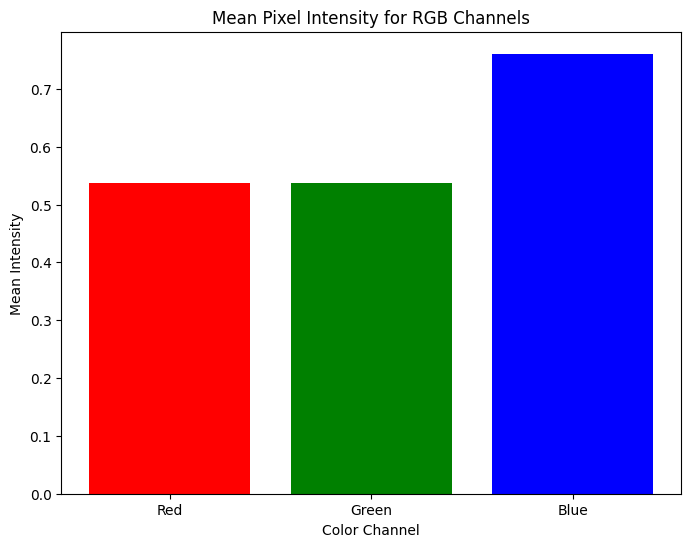

In [12]:
# Calculate mean pixel intensity for each channel
mean_red = np.mean(train_images[:, :, :, 0])
mean_green = np.mean(train_images[:, :, :, 1])
mean_blue = np.mean(train_images[:, :, :, 2])

# Create a bar chart to show mean pixel intensity for each channel
plt.figure(figsize=(8, 6))
plt.bar(['Red', 'Green', 'Blue'], [mean_red, mean_green, mean_blue], color=['red', 'green', 'blue'])
plt.title('Mean Pixel Intensity for RGB Channels')
plt.xlabel('Color Channel')
plt.ylabel('Mean Intensity')
plt.show()


#### `Visualizing Class Distributions with Color Channels`

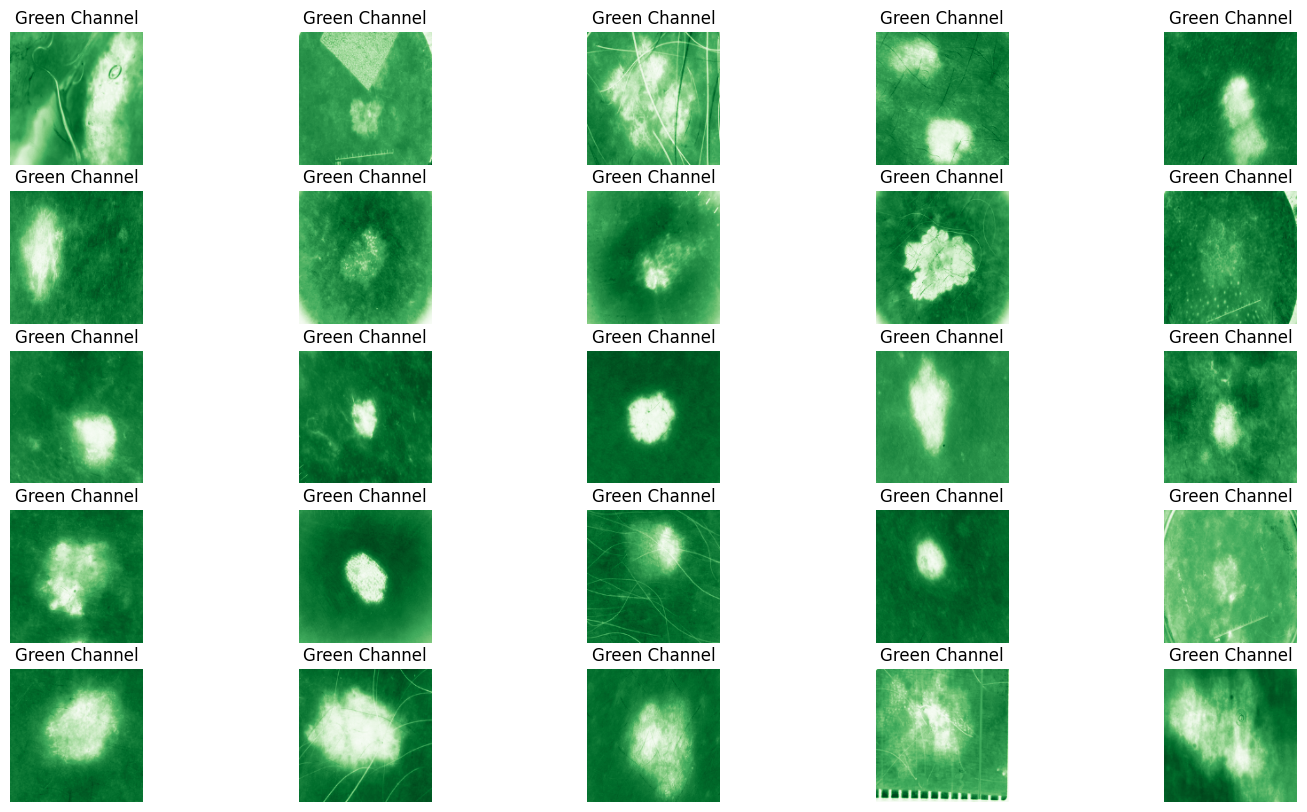

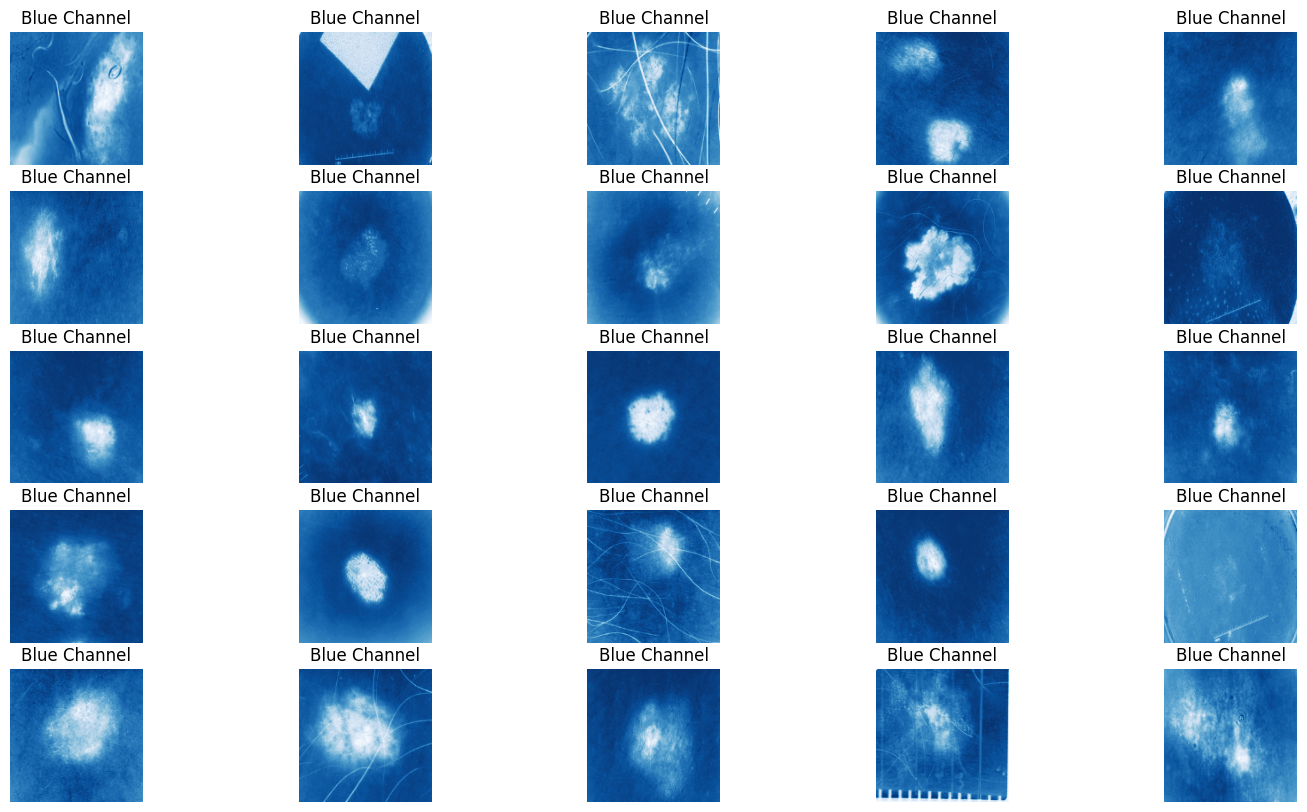

In [13]:
# Display sample images with separate color channels
plt.figure(figsize=(18, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i][:, :, 0], cmap='Reds')  # Red channel
    plt.title("Red Channel")
    plt.axis('off')
plt.show()

plt.figure(figsize=(18, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i][:, :, 1], cmap='Greens')  # Green channel
    plt.title("Green Channel")
    plt.axis('off')
plt.show()

plt.figure(figsize=(18, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i][:, :, 2], cmap='Blues')  # Blue channel
    plt.title("Blue Channel")
    plt.axis('off')
plt.show()


## The Model

In [14]:

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks 
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_images, train_labels, epochs=100, batch_size=32,
                    validation_data=(val_images, val_labels),
                    callbacks=[checkpoint, early_stopping])


Epoch 1/100
66/66 [==============================] - ETA: 0s - loss: 0.6458 - accuracy: 0.6434
Epoch 1: val_accuracy improved from -inf to 0.76705, saving model to best_model.h5
66/66 [==============================] - 11s 41ms/step - loss: 0.6458 - accuracy: 0.6434 - val_loss: 0.5561 - val_accuracy: 0.7670
Epoch 2/100
66/66 [==============================] - ETA: 0s - loss: 0.5154 - accuracy: 0.7387
Epoch 2: val_accuracy improved from 0.76705 to 0.78977, saving model to best_model.h5
66/66 [==============================] - 2s 29ms/step - loss: 0.5154 - accuracy: 0.7387 - val_loss: 0.4885 - val_accuracy: 0.7898
Epoch 3/100
63/66 [===========================>..] - ETA: 0s - loss: 0.4404 - accuracy: 0.7827
Epoch 3: val_accuracy improved from 0.78977 to 0.79356, saving model to best_model.h5
66/66 [==============================] - 2s 30ms/step - loss: 0.4392 - accuracy: 0.7852 - val_loss: 0.4221 - val_accuracy: 0.7936
Epoch 4/100
65/66 [============================>.] - ETA: 0s - loss: 

#### `Plotting training history`

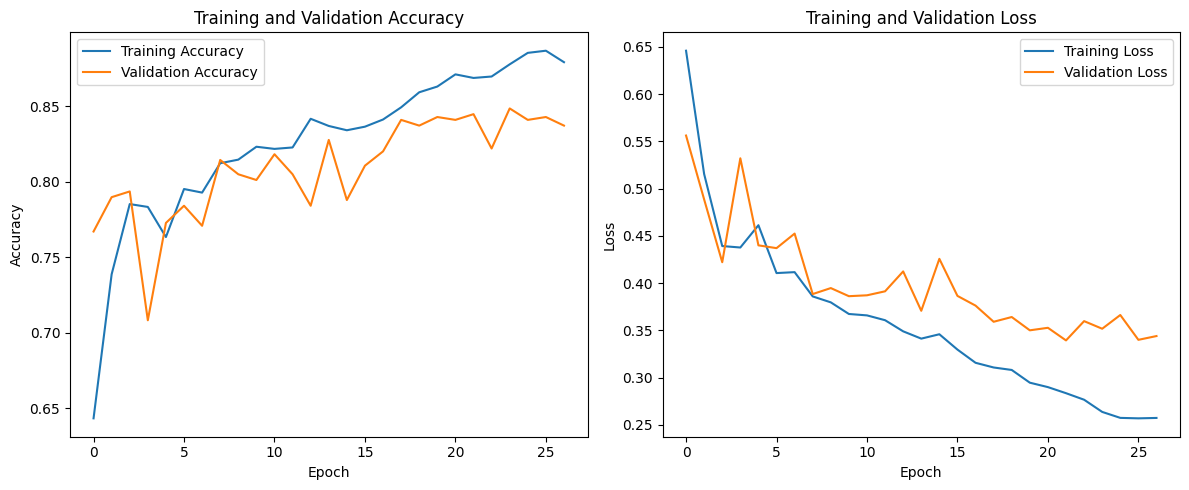

In [15]:

# Plotting training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

#### `Evaluation And Prediction`

In [16]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

# Make predictions on the test set
predictions = model.predict(test_images)
predicted_labels = (predictions > 0.5).astype('int32').reshape(-1)  # Convert probabilities to binary predictions (0 or 1)



83/83 [==============================] - 1s 8ms/step - loss: 0.3047 - accuracy: 0.8733
Test Accuracy: 87.33%
Test Loss: 0.3047
83/83 [==============================] - 1s 6ms/step


#### `Predictions vs Actual`

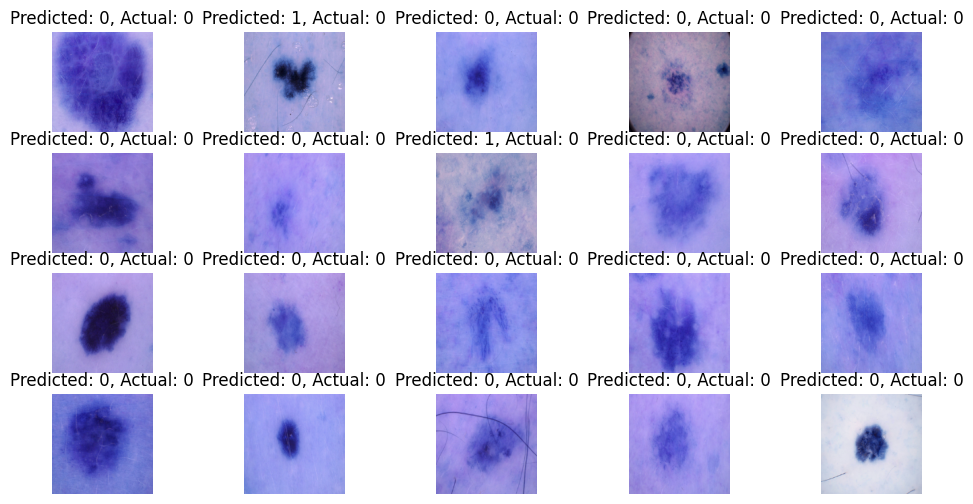

In [17]:
# Visualize predictions vs actual labels
plt.figure(figsize=(12, 6))
for i in range(20):  # Display a few predictions
    plt.subplot(4, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"Predicted: {predicted_labels[i]}, Actual: {test_labels[i]}")
    plt.axis('off')
plt.show()

## `By: Mohammed Hamza`